<a href="https://colab.research.google.com/github/shaheriar/CS-228-Deep-Learning-Project/blob/Experimental-Changes/CS228FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 228 Final Project
## Enhancing Image Captioning with Deep Learning Models
### Saul Gonzalez - sgonz081
### Shaheriar Malik - smali032

Dataset: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

Image captioning is a difficult task that is one step above image classification since we are
generating an actual text description of each image. So, deep learning would be an obvious choice in this case since generating text for a variable input image is a difficult task that would require a complex model.


In [32]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchtext.data import get_tokenizer
from torchtext.data.metrics import bleu_score
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
from torchtext.data.metrics import bleu_score

from copy import deepcopy

from PIL import Image
import nltk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

import random
import os
import natsort
import cv2
from collections import Counter, OrderedDict

from textwrap import wrap
from IPython.display import clear_output

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!unzip -n "/content/drive/MyDrive/ImageCaptioningDataset/flickr30k_images.zip" -d "/content"
clear_output()

In [34]:
raw_df = pd.read_csv('/content/drive/MyDrive/ImageCaptioningDataset/results.csv', sep='|', header = None)
#raw_df.drop([' comment_number'],axis=1, inplace=True)
#raw_df.columns = raw_df.columns.str.replace(' ', '')
#raw_df.loc[19999,'comment'] = 'A dog runs across the grass .'
#raw_df.to_csv('out.csv',sep='|',index=False)
#raw_df.iloc[[19999]]

In [35]:
# read, resize and zero pad images. Returns image tensor [3, 256, 256]
def readImage(path):
    desired_size = 256 # 256 x 256
    image = cv2.imread(path)
    old_size = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    transform = transforms.ToTensor()
    tensor = transform(new_im)
    return tensor

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    num = temp_df.shape[0]
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
        image = readImage(f"/content/flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(image.permute(1, 2, 0))
        plt.title("\n".join(wrap(temp_df.comment[i], 30)))

#num = 5
#display_images(raw_df.sample(num))

In [36]:
# Build vocabulary for Captions
def build_vocab(captions,tokenizer,max_len):
  counter = Counter()
  current_max = max_len
  for caption in captions:
    sentence = caption.strip()
    tokens = tokenizer(sentence)
    if len(tokens) > current_max:
      current_max = len(tokens)
    counter.update(tokens)
  sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
  dictionary = OrderedDict(sorted_by_freq)
  dictionary = dict(dictionary)
  dictionary = OrderedDict(dictionary)
  return vocab(dictionary,specials=['<PAD>','<SOS>','<EOS>','<UNK>']), current_max

In [37]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, label_csv, transform=None):
        self.data_dir = data_dir
        self.target_len = -1

        self.data_df = pd.read_csv(label_csv, sep='|',header=None)
        self.data_df = self.data_df.dropna()
        #self.data_df.drop([' comment_number'],axis=1, inplace=True)
        #self.data_df.columns = self.data_df.columns.str.replace(' ', '')
        self.captions = self.data_df[1] # 0 is image_name, 1 is comment
        self.captions = self.captions.apply(lambda x: x.lower())
        self.captions = self.captions.apply(lambda x: x.replace("[^A-Za-z]",""))
        self.captions = self.captions.apply(lambda x: x.replace("\s+"," "))
        self.captions = self.captions.apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

        self.transform = transform
        self.image_paths = self.data_df[0]#os.listdir(data_dir)  # Assumes images are directly under data_dir

        self.tokenizer = get_tokenizer("basic_english")
        self.vocab, self.target_len = build_vocab(self.captions.tolist(),self.tokenizer,self.target_len)
        self.target_len += 2
        self.vocab.set_default_index(self.vocab['<UNK>'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = (image - np.mean(image))/np.std(image) # normalize
        image = Image.fromarray(image)# * 255).astype(np.uint8))
        # = Image.open(image_path).convert("RGB")
        caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)

        # Vectorize the given caption using our dataset's vocabulary
        caption = caption.strip()
        caption = self.tokenizer(caption)
        caption_vector = [self.vocab['<SOS>']]
        caption_vector.extend([self.vocab[word] for word in caption])
        caption_vector.append(self.vocab['<EOS>'])

        # Add padding to the vector if it needs it
        if len(caption_vector) < self.target_len:
          for i in range(self.target_len - len(caption_vector)):
            caption_vector.append(self.vocab['<PAD>'])

        # Return the processed image and any associated labels
        return image, torch.tensor(caption_vector)

In [247]:
weights = models.Wide_ResNet50_2_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

data_dir = '/content/flickr30k_images/'
label_csv = '/content/drive/MyDrive/ImageCaptioningDataset/results.csv'
dataset = CustomDataset(data_dir, label_csv, transform=preprocess)
len(dataset)

158915

In [39]:
test,train = random_split(dataset, [int(len(dataset)*0.3)+1, int(len(dataset)*0.7)])
print(len(test),len(train))

47675 111240


In [40]:
image_paths = raw_df[0]
image_paths[0]

'1000092795.jpg'

In [41]:
batch_size = 37
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [42]:
vocab_size = len(dataset.vocab)
vocab_size

20205

In [43]:
# import time
# i = 0
# for img, file_name in dataloader:
#   clear_output()
#   #print(label[0])
#   #print(raw_df['image_name'])
#   plt.imshow(img[0].permute(1,2,0))
#   print(list(raw_df.loc[raw_df['image_name'] == file_name[0]].comment)[0])
#   i+=5
#   plt.show()
#   time.sleep(1)

## Encoder & Decoder

In [44]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [45]:
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [46]:
class Encoder(nn.Module):
  def __init__(self,embed_size):
    super(Encoder, self).__init__()
    # Load the pretrained ResNet-101 model
    self.resnet = models.wide_resnet50_2(weights=weights)
    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)

  def forward(self,images):
    features = self.resnet(images)
    features = features.unsqueeze(1)
    return features

In [344]:
class Decoder(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=dataset.vocab['<PAD>'])
    self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
    self.attention = nn.Linear(embed_size,embed_size)
    self.fc = nn.Linear(hidden_size, vocab_size)

  def forward(self, features, captions):
      attention_weights = torch.softmax(self.attention(features), dim=1)
      self.attention_weights = attention_weights.detach().cpu().numpy()

      attention_encoding = attention_weights * features
      self.attention_encoding = attention_encoding.detach().cpu().numpy()

      embeddings = self.embedding(captions)
      combined = torch.cat((attention_encoding, embeddings), dim=1)

      lstm_out, _ = self.lstm(combined)

      outputs = self.fc(lstm_out)
      return outputs

In [345]:
embed_size = 256
hidden_size = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

encoder = Encoder(embed_size).to(device)
for param in encoder.parameters():
    param.requires_grad = False

decoder = Decoder(embed_size, hidden_size, vocab_size).to(device)

In [50]:
#resume(decoder,'/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder_v2.pt')

In [51]:
def training():
  criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
  optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
  num_epochs = 10
  start_epoch = 5
  
  for epoch in range(start_epoch,num_epochs):
    encoder.eval()
    decoder.train()
    i = 0
    for images, captions in train_loader:
        images = images.to(device, dtype=torch.float)
        captions = captions.to(device)
        

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions[:,:-1])
        
        # Reshape captions for loss calculation
        targets = captions[:, :].reshape(-1)
        
        #print(targets.shape)

        # Compute loss
        #print(targets.size())
        loss = criterion(outputs.reshape(-1, vocab_size), targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss
        if i % 100 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, len(train_loader), loss.item()))
        i+=1
    # Create a checkpoint for training
    checkpoint(decoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder-epoch-{epoch}.pth")

#training()

In [52]:
#checkpoint(encoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_encoder.pth")
#checkpoint(decoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder.pth")

In [346]:
embed_size = 256
hidden_size = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

encoder = Encoder(embed_size)
decoder = Decoder(embed_size, hidden_size, vocab_size)
encoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/attn_encoder.pth',map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder.pth',map_location=torch.device('cpu')))
encoder.to(device)
decoder.to(device)

Decoder(
  (embedding): Embedding(20205, 256, padding_idx=0)
  (lstm): LSTM(256, 512, batch_first=True)
  (attention): Linear(in_features=256, out_features=256, bias=True)
  (fc): Linear(in_features=512, out_features=20205, bias=True)
)

In [366]:
def inference_function(image):
  encoder.eval()
  decoder.eval()
  features = encoder(image)

  caption = [dataset.vocab['<SOS>']]
  with torch.no_grad():
    while len(caption) < dataset.target_len and caption[-1] != dataset.vocab['<EOS>']:
      # features = features.to(device, dtype=torch.float)
      captions = torch.tensor(caption).unsqueeze(0).to(device)
      #print(captions[0])
      outputs = decoder(features, captions)
      #print(outputs.argmax(2))
      _, pred_words = torch.max(outputs,2)
      pred_words = pred_words.cpu().numpy()
      caption.append(pred_words[-1][-1])
  i = 0
  full_caption = []
  for idx in caption:
    if dataset.vocab.lookup_token(idx) not in ['<PAD>','<SOS>','<EOS>']:
      #print(dataset.vocab.lookup_token(idx))
      full_caption.append(dataset.vocab.lookup_token(idx))
      i += 1
  #full_caption = [dataset.vocab.lookup_token(idx) for idx in caption if dataset.vocab.lookup_token(idx) not in ['<PAD','<SOS>','<EOS>']]
  return full_caption

woman in red shirt is holding up sign saying costume


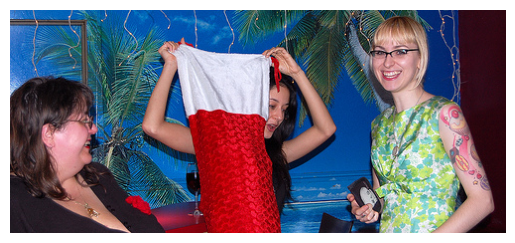

In [367]:
k = random.randint(0, len(dataset))
normal_image_path = os.path.join(dataset.data_dir, dataset.image_paths[k])
normal_image = cv2.imread(normal_image_path)
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)
image = dataset[k][0].unsqueeze(0)
image = image.to(device, dtype=torch.float)
full_caption = inference_function(image)
plt.figure()
plt.axis('off')
plt.imshow(normal_image,aspect='equal')
print(' '.join(full_caption))

In [384]:
decoder.attention_weights.shape

(1, 1, 256)

group of people are standing in front of large crowd


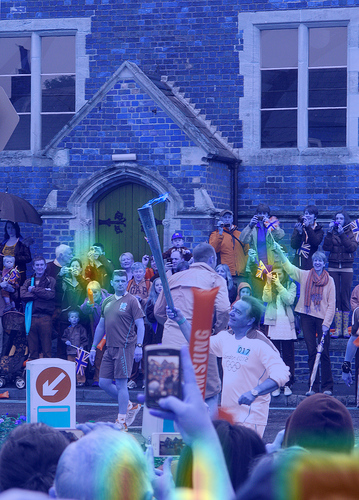

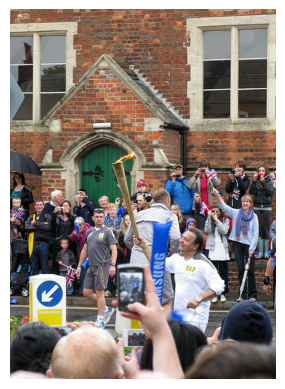

In [385]:
import torch
from google.colab.patches import cv2_imshow
# Resize attention weights to match image dimensions
k = random.randint(0, len(dataset))
normal_image_path = os.path.join(dataset.data_dir, dataset.image_paths[k])
normal_image = cv2.imread(normal_image_path)
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)
image = dataset[k][0].unsqueeze(0)
image = image.to(device, dtype=torch.float)
full_caption = inference_function(image)
plt.figure()
plt.axis('off')
plt.imshow(normal_image,aspect='equal')
attention_weights = decoder.attention_weights[0]  # Assuming attention_weights has shape (H', W')
attention_weights_tensor = torch.from_numpy(attention_weights)

resized_attention_weights = F.interpolate(torch.unsqueeze(torch.unsqueeze(attention_weights_tensor, 0), 0),
                                          size=(10, 10),
                                          mode='bilinear',
                                          align_corners=False)
resized_attention_weights = resized_attention_weights.squeeze().squeeze().detach().cpu().numpy()
normalized_attention_weights = (resized_attention_weights - resized_attention_weights.min()) / (
    resized_attention_weights.max() - resized_attention_weights.min()
)

# Load the image
image = normal_image
heatmap = cv2.applyColorMap(np.uint8(255 * normalized_attention_weights), cv2.COLORMAP_JET)
# Resize the heatmap to match the image dimensions
resized_heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# Normalize the resized heatmap between 0 and 1
normalized_heatmap = cv2.normalize(resized_heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Convert the heatmap to a color map
colormap = cv2.applyColorMap(normalized_heatmap, cv2.COLORMAP_JET)

# Blend the heatmap with the original image
attention_map = cv2.addWeighted(image, 0.7, colormap, 0.3, 0)

# Display the attention map
print(' '.join(full_caption))
cv2_imshow(attention_map)

In [58]:
#from google.colab import files
#torch.save(encoder.state_dict(), 'encoder.pth')

# download checkpoint file
#files.download('encoder.pth')

In [59]:
#torch.save(decoder.state_dict(), 'decoder.pth')

# download checkpoint file
#files.download('decoder.pth')

In [60]:
def mixup(x, y, a):
    lam = np.random.beta(a,a)
    rand = torch.randperm(batch_size)
    x2 = x[rand,:]
    y2 = y[rand,:]
    X = lam * x + (1 - lam) * x2
    Y = lam * y + (1 - lam) * y2
    #print(Y)
    return X, Y

def cutout(image, k):
    x = np.random.randint(0, 128-k)
    y = np.random.randint(0, 128-k)
    image[:, x:x+k, y:y+k] = 0
    return image

def standard_augmentation(image,k):
    k1 = np.random.randint(-k, k)
    k2 = np.random.randint(-k, k)
    image = np.roll(image, k1, axis=1)
    image = np.roll(image, k2, axis=2)
    if (k1 > 0):    
        image[:, :k1, :] = 0
    else:
        image[:, k1:, :] = 0
    if (k2 > 0):
        image[:, :, :k2] = 0
    else:
        image[:, :, k2:] = 0
    if (np.random.rand() < 0.5):
        image = np.flip(image, axis=2)
    return image